In [3]:
# load packages
import kagglehub
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import matplotlib.ticker as ticker
import warnings

In [4]:
# download latest version
path = kagglehub.dataset_download("marianadeem755/stock-market-data")

# set path to the dataset folder
path = Path(path)

# set full path to the CSV file
file_path = path / "15 Years Stock Data of NVDA AAPL MSFT GOOGL and AMZN.csv"

# load it
df = pd.read_csv(file_path)

# first 5 rows
df.head()

,Date,Close_AAPL,Close_AMZN,Close_GOOGL,Close_MSFT,Close_NVDA,High_AAPL,High_AMZN,High_GOOGL,High_MSFT,...,Open_AAPL,Open_AMZN,Open_GOOGL,Open_MSFT,Open_NVDA,Volume_AAPL,Volume_AMZN,Volume_GOOGL,Volume_MSFT,Volume_NVDA
0,2010-01-04,6.440330,6.6950,15.609805,23.254051,0.423884,6.455075,6.8305,15.678546,23.366752,...,6.422875,6.8125,15.614786,23.006108,0.424342,493729600,151998000,78169752,38409100,800204000
1,2010-01-05,6.451465,6.7345,15.541064,23.261557,0.430073,6.487878,6.7740,15.636953,23.366746,...,6.458086,6.6715,15.620515,23.178910,0.422279,601904800,177038000,120067812,49749600,728648000
2,2010-01-06,6.348847,6.6125,15.149294,23.118809,0.432824,6.477046,6.7365,15.587638,23.351725,...,6.451466,6.7300,15.587638,23.201455,0.429844,552160000,143576000,158988852,58182400,649168000
3,2010-01-07,6.337109,6.5000,14.796624,22.878376,0.424342,6.379842,6.6160,15.192630,23.066212,...,6.372319,6.6005,15.177685,23.013616,0.430532,477131200,220604000,256315428,50559700,547792000
4,2010-01-08,6.379242,6.6760,14.993881,23.036165,0.425259,6.379844,6.6840,15.024515,23.201460,...,6.328685,6.5280,14.744323,22.750656,0.420903,447610800,196610000,188783028,51197400,478168000


In [5]:
df_amzn = df[['Date','Close_AMZN']].copy()
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])
df_amzn = df_amzn.sort_values(by='Date')
df_amzn.set_index('Date', inplace=True)
df_amzn = df_amzn.asfreq('B')
df_amzn.dropna(inplace=True)
df_amzn.head()

,Close_AMZN
Date,
2010-01-04,6.6950
2010-01-05,6.7345
2010-01-06,6.6125
2010-01-07,6.5000
2010-01-08,6.6760


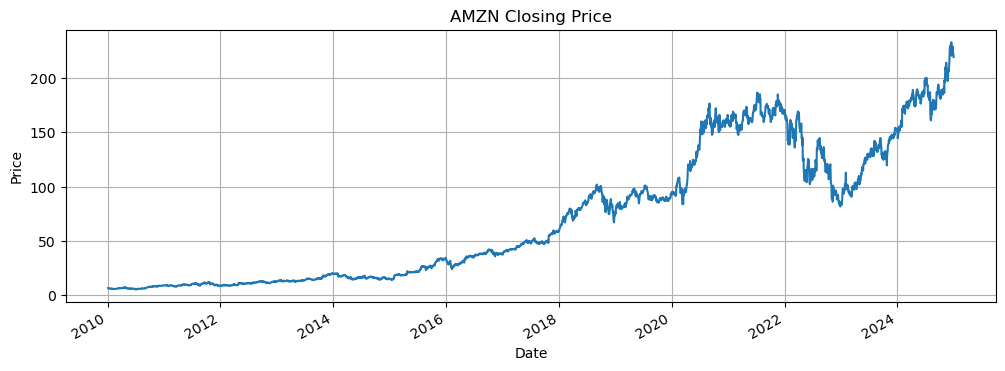

In [6]:
df_amzn['Close_AMZN'].plot(figsize=(12, 4), title='AMZN Closing Price')
plt.ylabel('Price')
plt.grid()
plt.show()

In [7]:
# Perform Augmented Dickey-Fuller (ADF) test
# Null hypothesis: the time series is non-stationary
# Alternative hypothesis: the time series is stationary

result = adfuller(df_amzn['Close_AMZN'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value:.4f}')

ADF Statistic: 0.6734836882159844
p-value: 0.9892935605889442
Critical Values:
   1%: -3.4321
   5%: -2.8623
   10%: -2.5672


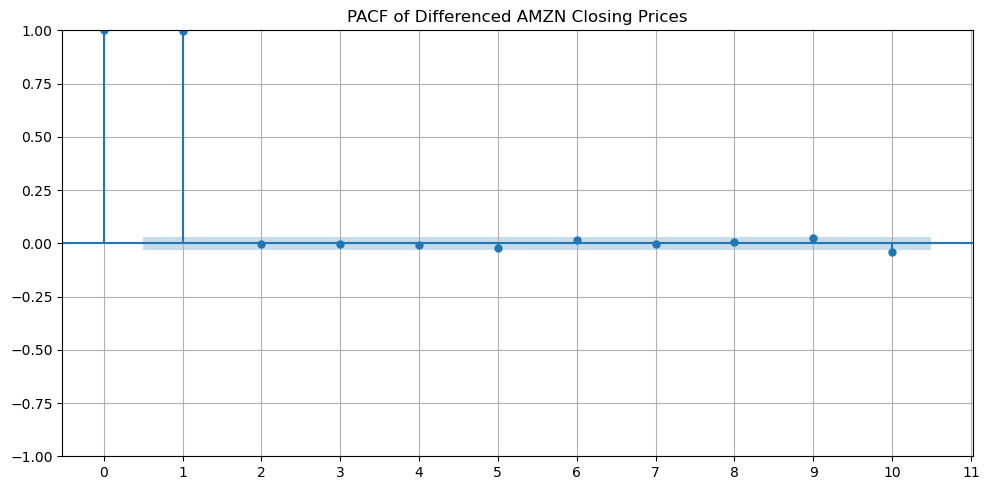

In [8]:
# plot the Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(df_amzn['Close_AMZN'], lags=10, method='ywm', ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('PACF of Differenced AMZN Closing Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Lag 1 is significant, which suggests that the AR term should be included in the model.

<Figure size 1000x500 with 0 Axes>

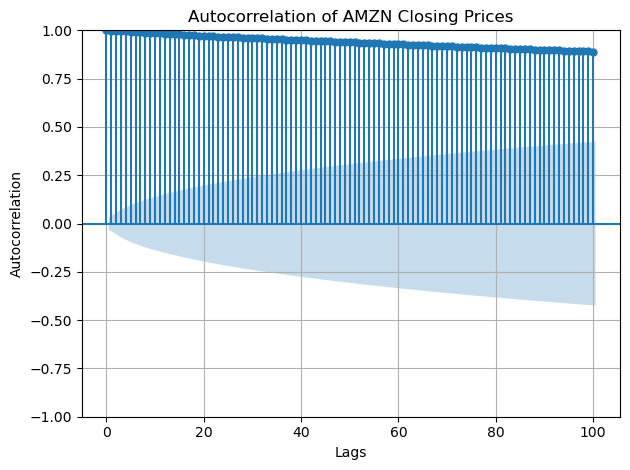

In [9]:
# plot the Autocorrelation Function (ACF)
plt.figure(figsize=(10, 5))
plot_acf(df_amzn['Close_AMZN'], lags=100)
plt.title('Autocorrelation of AMZN Closing Prices')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

# High auttocorrelation suggests that the time series is non-stationary and must be differenced

<Figure size 1000x500 with 0 Axes>

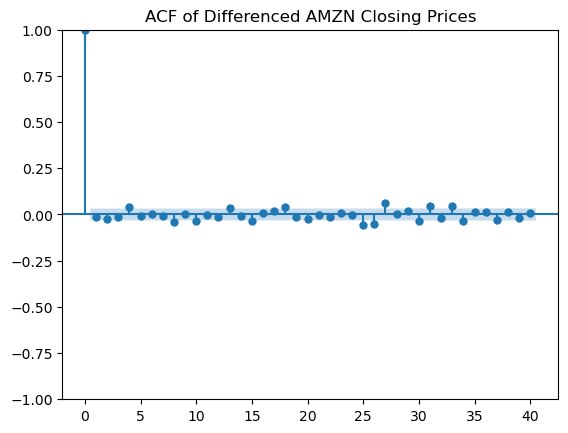

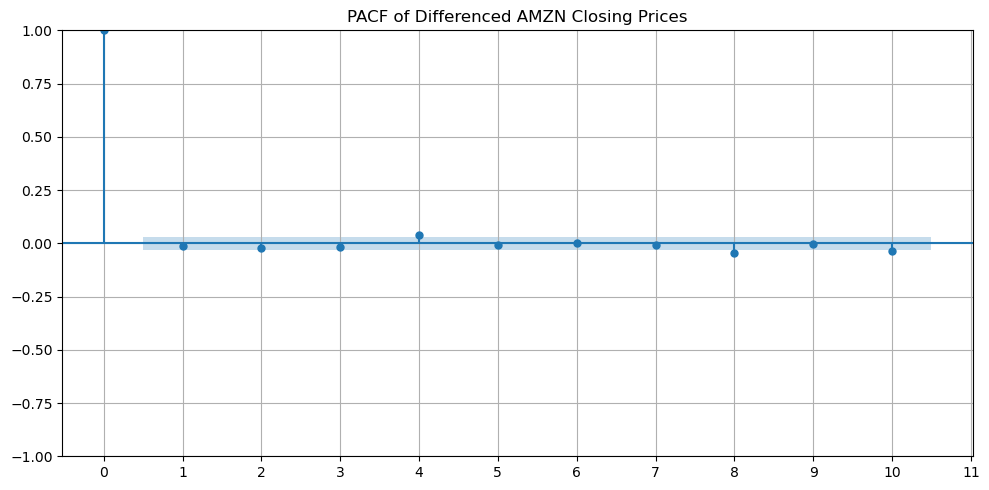

In [10]:
# difference the series to remove trend (d=1)
df_amzn['Close_AMZN_diff'] = df_amzn['Close_AMZN'].diff()
df_amzn.dropna(inplace=True)  # drop the first NaN

# plot ACF of differenced series
plt.figure(figsize=(10, 5))
plot_acf(df_amzn['Close_AMZN_diff'], lags=40)
plt.title('ACF of Differenced AMZN Closing Prices')
plt.show()

# plot PACF of differenced series
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(df_amzn['Close_AMZN_diff'], lags=10, method='ywm', ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # <- This sets ticks at every 1 lag
plt.title('PACF of Differenced AMZN Closing Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# The ACF plot shows a significant spike at lag 1 and then tails off, suggesting an MA(1) model.
# The PACF plot does not show a significant spike after lag 0, suggesting an AR(0) model.
# Based on the ACF and PACF plots, we can try an ARIMA(0,1,1) model.

In [11]:
# fit the ARIMA model based on the ACF and PACF plots where p=0, d=1, q=1 

model = ARIMA(df_amzn['Close_AMZN'], order=(0, 1, 0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_AMZN   No. Observations:                 3773
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -7816.200
Date:                Wed, 07 May 2025   AIC                          15634.401
Time:                        15:59:02   BIC                          15640.636
Sample:                             0   HQIC                         15636.618
                               - 3773                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.6930      0.030    121.182      0.000       3.633       3.753
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):             29162.69
Prob(Q):                              0.38   Pr

c:\Users\kente\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kente\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kente\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# time series cross-validation df to choose the best ARIMA model parameters
series = df_amzn['Close_AMZN'].replace([np.inf, -np.inf], np.nan).dropna()

warnings.filterwarnings("ignore")

In [15]:
def time_series_cv(series, order, initial_train_size=365, horizon=10, step=21):
    errors = []
    max_folds = (len(series) - initial_train_size - horizon) // step

    for i in range(max_folds):
        train_end = initial_train_size + i
        train = series[:train_end]
        test = series[train_end:train_end + horizon]

        if len(test) < horizon:
            break

        try:
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=horizon)
            rmse = np.sqrt(mean_squared_error(test, forecast))
            errors.append(rmse)
        except:
            continue

    return np.mean(errors) if errors else None

# define parameter grid
p_values = range(0, 4)
d_values = [1]
q_values = range(0, 4)

cv_results = []
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                order = (p, d, q)
                model = ARIMA(series, order=order)
                model_fit = model.fit()
                aic = model_fit.aic
                rmse_cv = time_series_cv(series, order, step=21)
                if rmse_cv is not None:
                    cv_results.append({
                        'order': order,
                        'aic': aic,
                        'rmse_cv': rmse_cv
                    })
            except:
                continue

rmse_cv_results_df = pd.DataFrame(cv_results).sort_values(by='rmse_cv').reset_index(drop=True)
print(rmse_cv_results_df)

        order           aic   rmse_cv
0   (0, 1, 0)  15634.400923  0.546464
1   (1, 1, 3)  15636.005616  0.546671
2   (0, 1, 1)  15635.678138  0.546828
3   (1, 1, 0)  15635.711875  0.546831
4   (2, 1, 3)  15620.193941  0.546837
5   (0, 1, 2)  15635.755779  0.547255
6   (2, 1, 0)  15635.675318  0.547298
7   (0, 1, 3)  15637.044399  0.547318
8   (3, 1, 0)  15636.823566  0.547395
9   (3, 1, 2)  15633.920221  0.547498
10  (3, 1, 1)  15635.990427  0.548040
11  (2, 1, 2)  15610.437155  0.549234
12  (1, 1, 2)  15637.597512  0.551494
13  (2, 1, 1)  15638.485859  0.552203
14  (3, 1, 3)  15621.015500  0.552788
15  (1, 1, 1)  15635.544253  0.553805


In [16]:
def time_series_directional_accuracy(series, order, initial_train_size=365, horizon=10, step=21):
    """
    Cross-validation that computes directional accuracy for each fold.

    Returns:
    - float: Mean directional accuracy across folds
    """
    correct_directions = []
    max_folds = (len(series) - initial_train_size - horizon) // step

    for i in range(max_folds):
        train_end = initial_train_size + i * step
        test_start = train_end
        test_end = test_start + horizon

        train = series[:train_end]
        test = series[test_start:test_end]

        if len(test) < horizon:
            break

        try:
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=horizon)

            # Compare direction: up = 1, down = -1, flat = 0
            actual_diff = np.sign(np.diff(test.values))
            forecast_diff = np.sign(np.diff(forecast))

            correct = np.sum(actual_diff == forecast_diff)
            total = len(actual_diff)

            if total > 0:
                correct_directions.append(correct / total)
        except:
            continue

    return np.mean(correct_directions) if correct_directions else None

# define parameter grid
p_values = range(0, 4)
d_values = [1]
q_values = range(0, 4)

cv_results = []
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                order = (p, d, q)
                model = ARIMA(series, order=order)
                model_fit = model.fit()
                aic = model_fit.aic
                acc = time_series_directional_accuracy(series, order, step=21)
                if acc is not None:
                    cv_results.append({
                        'order': order,
                        'aic': aic,
                        'directional_accuracy': acc
                    })
            except:
                continue

dir_acc_cv_results_df = pd.DataFrame(cv_results).sort_values(by='directional_accuracy').reset_index(drop=True)
print(dir_acc_cv_results_df)

        order           aic  directional_accuracy
0   (0, 1, 0)  15634.400923              0.002070
1   (0, 1, 1)  15635.678138              0.002070
2   (0, 1, 2)  15635.755779              0.057971
3   (0, 1, 3)  15637.044399              0.110421
4   (1, 1, 0)  15635.711875              0.383023
5   (1, 1, 1)  15635.544253              0.478951
6   (1, 1, 2)  15637.597512              0.493444
7   (2, 1, 0)  15635.675318              0.500345
8   (3, 1, 0)  15636.823566              0.501035
9   (2, 1, 1)  15638.485859              0.502415
10  (2, 1, 3)  15620.193941              0.502415
11  (3, 1, 2)  15633.920221              0.509317
12  (3, 1, 3)  15621.015500              0.510417
13  (3, 1, 1)  15635.990427              0.510697
14  (2, 1, 2)  15610.437155              0.513458
15  (1, 1, 3)  15636.005616              0.523119


In [ ]:
# join RMSE results with directional accuracy results
arima_results_df = pd.merge(rmse_cv_results_df, dir_acc_cv_results_df[['order','directional_accuracy']], on='order')
arima_results_df.head()

,order,aic,rmse_cv,directional_accuracy
0,"(0, 1, 0)",15634.400923,0.546464,0.002070
1,"(1, 1, 3)",15636.005616,0.546671,0.523119
2,"(0, 1, 1)",15635.678138,0.546828,0.002070
3,"(1, 1, 0)",15635.711875,0.546831,0.383023
4,"(2, 1, 3)",15620.193941,0.546837,0.502415


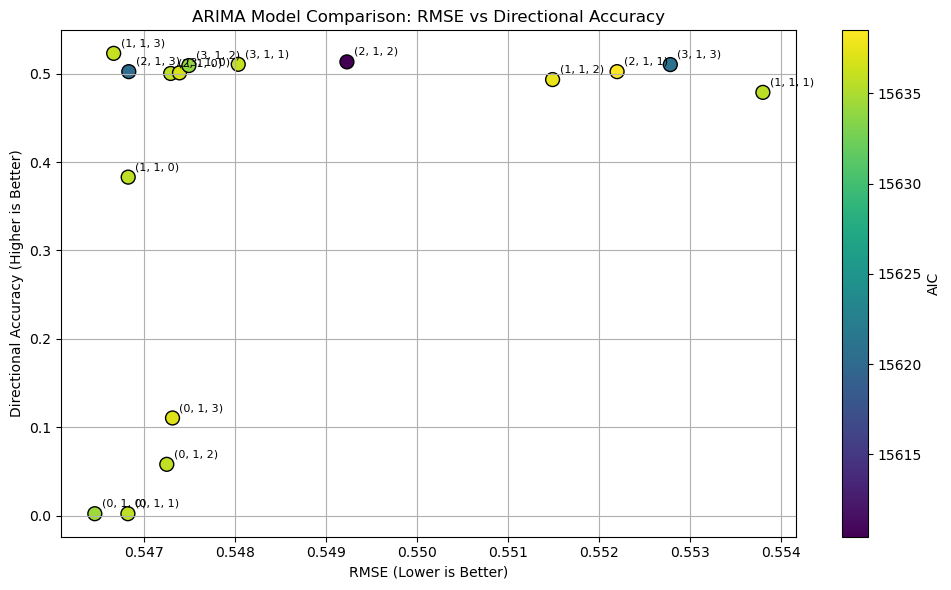

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sc = ax.scatter(
    arima_results_df['rmse_cv'],
    arima_results_df['directional_accuracy'],
    c=arima_results_df['aic'],
    cmap='viridis',
    s=100,
    edgecolors='black'
)

# label each point with the ARIMA order, offset slightly to avoid overlap
for i, row in arima_results_df.iterrows():
    ax.annotate(
        str(row['order']),
        (row['rmse_cv'], row['directional_accuracy']),
        textcoords="offset points",
        xytext=(5, 5), 
        ha='left',
        fontsize=8
    )

# axis labels and title
ax.set_xlabel('RMSE (Lower is Better)')
ax.set_ylabel('Directional Accuracy (Higher is Better)')
ax.set_title('ARIMA Model Comparison: RMSE vs Directional Accuracy')

# colorbar for AIC
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('AIC')

plt.grid(True)
plt.tight_layout()
plt.show()

# (0,1,0) has the lowest RMSE and (1,1,3) has the highest directional accuracy.
# (1,1,3) is the best model based on directional accuracy, without sacrificing too much RMSE.

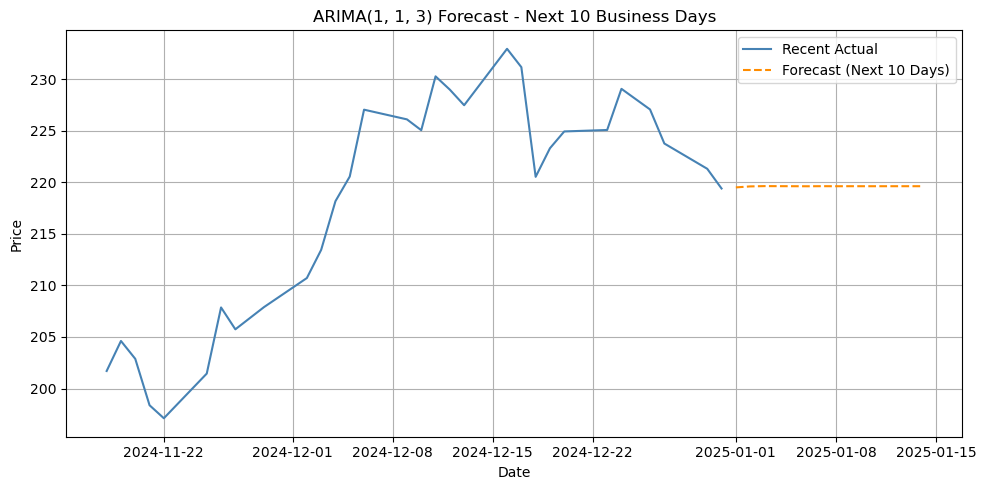

In [ ]:
# fit ARIMA model
best_order = (1, 1, 3)
model = ARIMA(series, order=best_order)
model_fit = model.fit()

# forecast the next 10 days
forecast_steps = 10
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean

# create a datetime index for the forecast
last_date = series.index[-1]
forecast_index = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)
forecast_series = pd.Series(forecast_mean.values, index=forecast_index)

# recent actuals for plotting context
recent_actual = series[-30:]

# plotting
plt.figure(figsize=(10, 5))
plt.plot(recent_actual, label='Recent Actual', color='steelblue')
plt.plot(forecast_series, label='Forecast (Next 10 Days)', color='darkorange', linestyle='--')
plt.title(f'ARIMA{best_order} Forecast - Next 10 Business Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()